In [1]:
import ccxt
from datetime import datetime as dt,timedelta
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import vectorbt as vbt
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas_ta as ta


In [2]:


class bot_tao:
    def __init__(self, exchange):
        self.ex  = exchange
        self.period = 365
        print(f'Activate  : Exchange {exchange.name}')
    
    def get_data(self,symbols,timeframe='1d'):
        
        data= pd.DataFrame(self.ex.fetch_ohlcv(symbols,timeframe),columns=['date','open','high','low','close','volume'])
#         data.drop(columns='volume',inplace=True)
        data['date']=data['date'].apply(self.ex.iso8601)
        data['date']=pd.to_datetime(data['date'])
    #   df['date']=df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
    #   df['date']=pd.to_datetime(df['date'])
        data.set_index('date',inplace=True)
        
        return data

    def cal_consecutive(self,df):

        df['win']= np.sign(df) # assign sign on log
        blocks = df['win'].ne(df['win'].shift()).cumsum() 
        df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
        return df['consecutive_WL'] 
    
    def daily_returns(self,dataframe):
        ret = np.log(dataframe/dataframe.shift(1))
    #     res = (prices/prices.shift(1) - 1.0)[1:]

        return ret

    
    
    def sharpe(self,adj_ret,risk_free=0):
#         adj_ret = self.daily_returns(prices) - risk_free
        sharpe_ratio =(np.nanmean(adj_ret) * np.sqrt(self.period) ) / np.nanstd(adj_ret)
        return sharpe_ratio
    
    
    
    def downside_risk(self,returns, risk_free=0):
        adj_returns = returns - risk_free
        downside =np.where(adj_ret<0,adj_ret,0)
        sqr_downside = np.square(downside)
        return np.sqrt(np.nanmean(sqr_downside) * 252)
#         return np.sqrt(sqr_downside.mean()*252) nan error


    def sortino(self,returns, risk_free=0):
        adj_returns = returns - risk_free
        drisk = self.downside_risk(adj_returns)

        if drisk == 0:
            return np.nan

        return (np.nanmean(adj_returns) * np.sqrt(252))/ drisk
    
    def cumulative_returns(self,returns):

        res = (returns + 1.0).cumprod()

        return res

    def max_drawdown(self,cum_returns):

        max_returns = np.fmax.accumulate(cum_returns)
    #     max_returns =cr.cummax()
        res = cum_returns / max_returns - 1 ## daily DD / Max DD -1

        res.columns = ['max drawdown']

        return res
    def annual_returns(self,returns,period=252):

        num_years = len(returns) / period

        cum_ret_final = (returns + 1).prod().squeeze()
#         (ret+1).cumprod().squeeze # 5.068042254764814
#         (adj_ret+1).cumprod()
        return cum_ret_final ** (1 / num_years) - 1


    def calmar(self,returns):

        max_dd = self.max_drawdown(self.cumulative_returns(returns)).min()#[-1]
#         if max_dd < 0:
#             return annual_returns(returns) / abs(max_dd)
        if max_dd < 0:
            return self.annual_returns(returns) / abs(max_dd) ## annual_ret  / abs(max_dd)

        return np.nan    
    
    def loadall_market_ftx(self):
#     exchange = ccxt.ftx()
        market = self.ex.load_markets()
        market_name =list(market.keys())
        market_trade= [market_name[i] for i in range(len(market_name)) \
                       if ('USD' in market_name[i]) & ('USDT' not in market_name[i]) & ('HALF' not in market_name[i] ) \
                     & ('BULL' not in market_name[i] ) & ('BEAR' not in market_name[i] ) & ('HEDGE' not in market_name[i] )]
        return market_trade

In [5]:
ex=ccxt.ftx({'enableRateLimit':True})
b=bot_tao(ex)
df =b.get_data('ZIL-PERP')
lrets = np.log(df['close']/df['close'].shift(1)).fillna(0)
df['log'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)

df['win']= np.sign(lrets)
blocks = df['win'].ne(df['win'].shift()).cumsum()
df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
df.drop(columns='win',inplace=True)

Activate  : Exchange FTX


In [7]:

short_shift = 20
long_shift =50
df['ATR']=df.ta.atr(short_shift,)
df['EMA_LONG'] = df.ta.ema(50)
df['EMA_SHORT'] = df.ta.ema(short_shift)
df['Momentum']=(df['EMA_LONG'] -df['EMA_LONG'].shift(short_shift) / df['close']-df['close'].shift(short_shift) ) \
/ df['close'].shift(short_shift)
df['P_ATR'] =df['ATR'] /df['close']
df

,open,high,low,close,volume,log,consecutive_WL,ATR,EMA_LONG,EMA_SHORT,Momentum,P_ATR
date,,,,,,,,,,,,
2021-03-03 00:00:00+00:00,0.11435,0.13160,0.112645,0.12641,3.445698e+06,0.000000,0.0,NaN,NaN,NaN,NaN,NaN
2021-03-04 00:00:00+00:00,0.12641,0.12884,0.115340,0.11881,1.493925e+06,-0.062005,-1.0,NaN,NaN,NaN,NaN,NaN
2021-03-05 00:00:00+00:00,0.11881,0.11886,0.109510,0.11595,6.059357e+05,-0.024367,-2.0,NaN,NaN,NaN,NaN,NaN
2021-03-06 00:00:00+00:00,0.11595,0.11843,0.111120,0.11600,3.213360e+05,0.000431,1.0,NaN,NaN,NaN,NaN,NaN
2021-03-07 00:00:00+00:00,0.11600,0.11950,0.114600,0.11804,4.305084e+05,0.017433,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27 00:00:00+00:00,0.09010,0.11841,0.084450,0.10580,4.637501e+08,0.161519,2.0,0.006753,0.049656,0.053674,-11.699259,0.063828
2022-03-28 00:00:00+00:00,0.10580,0.12065,0.097140,0.09906,2.530265e+08,-0.065825,-1.0,0.007591,0.051594,0.057997,-11.986484,0.076629
2022-03-29 00:00:00+00:00,0.09907,0.10764,0.096450,0.10283,1.197887e+08,0.037351,1.0,0.007771,0.053603,0.062267,-10.882599,0.075570


In [40]:
# df['signal'] =(df['EMA_SHORT'] >= df['EMA_LONG']).astype(int)
df['entry_sig'] =ta.above(df['EMA_SHORT'], df['EMA_LONG'],)
df['exit_sig'] = ta.below(df['EMA_SHORT'], df['EMA_LONG'],)

df['entry_cross'] = ((df['entry_sig']==1) & (df['entry_sig'].shift(1)==0)).astype(int)
df['exit_cross'] = ((df['exit_sig']==1) & (df['exit_sig'].shift(1)==0)).astype(int)


df['cross_date']=np.where(df['entry_cross']==1,df.index,\
         (np.where(df['exit_cross']==1,df.index,np.nan)))
df = df.fillna(method='ffill')
df['cross_time'] =df.index-df.cross_date

In [41]:
df.tail()

,open,high,low,close,volume,log,consecutive_WL,ATR,EMA_LONG,EMA_SHORT,Momentum,P_ATR,entry_sig,exit_sig,entry_cross,exit_cross,cross_date,cross_time
date,,,,,,,,,,,,,,,,,,
2021-12-29 00:00:00+00:00,177.2650,180.6325,170.0050,170.5950,1.584507e+08,-0.038353,-3.0,16.023643,189.885803,184.898783,0.041300,9.392797,0,1,0,0,2021-12-11 00:00:00+00:00,18 days
2021-12-30 00:00:00+00:00,170.5950,175.7700,168.1900,172.5325,1.080070e+08,0.011293,1.0,15.601461,189.205281,183.721041,0.126155,9.042621,0,1,0,0,2021-12-11 00:00:00+00:00,19 days
2021-12-31 00:00:00+00:00,172.5325,177.6850,167.6975,169.9600,1.354794e+08,-0.015023,-1.0,15.320763,188.450564,182.410466,0.087886,9.014334,0,1,0,0,2021-12-11 00:00:00+00:00,20 days
2022-01-01 00:00:00+00:00,169.9600,179.2175,169.9150,179.0925,7.760567e+07,0.052339,1.0,15.019849,188.083581,182.094469,0.081283,8.386643,0,1,0,0,2021-12-11 00:00:00+00:00,21 days
2022-01-02 00:00:00+00:00,179.0925,179.4975,175.2000,176.2025,2.365230e+07,-0.016269,-1.0,14.483732,187.617656,181.533329,0.201508,8.219936,0,1,0,0,2021-12-11 00:00:00+00:00,22 days


In [42]:
print((df[df['entry_cross']==1]).index[-1]) # last crossobver
df[df['exit_cross']==1]


2021-08-05 00:00:00+00:00


,open,high,low,close,volume,log,consecutive_WL,ATR,EMA_LONG,EMA_SHORT,Momentum,P_ATR,entry_sig,exit_sig,entry_cross,exit_cross,cross_date,cross_time
date,,,,,,,,,,,,,,,,,,
2020-10-04 00:00:00+00:00,2.5500,2.5850,2.420,2.5275,2.167300e+04,-0.008863,-7.0,0.427429,2.935245,2.915285,-0.464363,16.911120,0,1,0,1,2020-10-04 00:00:00+00:00,0 days
2021-06-01 00:00:00+00:00,32.7900,33.3275,29.825,30.9300,2.764646e+07,-0.058397,-1.0,7.230883,34.738814,34.696560,-0.222268,23.378218,0,1,0,1,2021-06-01 00:00:00+00:00,0 days
2021-06-22 00:00:00+00:00,26.6150,28.7675,20.140,26.9675,1.042239e+08,0.012970,1.0,6.058104,35.925154,35.639153,0.019217,22.464461,0,1,0,1,2021-06-22 00:00:00+00:00,0 days
2021-12-11 00:00:00+00:00,167.2475,173.7850,161.350,172.1475,1.536748e+08,0.030493,1.0,19.907044,199.490200,198.335207,-0.140442,11.563946,0,1,0,1,2021-12-11 00:00:00+00:00,0 days


In [43]:
# # np.where(consumption_energy > 400, 'high', 
# #          (np.where(consumption_energy < 200, 'low', 'medium')))
# # delta_t = np.where(df['entry_sig']==1,df.index-df.cross_date,(np.where(df['exit_sig']==1,df.index-df.cross_date,0)))

# col         = 'consumption_energy'
# conditions  = [ df2[col] >= 400, (df2[col] < 400) & (df2[col]> 200), df2[col] <= 200 ]
# choices     = [ "high", 'medium', 'low' ]
    
# df2["energy_class"] = np.select(conditions, choices, default=np.nan)
# ta.supertrend(df['high'], df['low'], df['close'], length=10, multiplier=3)

In [44]:
#  https://github.com/twopirllc/pandas-ta/blob/main/examples/VectorBT_Backtest_with_Pandas_TA.ipynb

In [45]:




from hurst import compute_Hc
######
df['hurst']=0
    #### Data Range to calculation ####
for i in range(120,len(df)):
        df.iloc[i,df.columns.get_loc('hurst')]=compute_Hc(df['close'].iloc[i-120:i-1], kind='price')[0]
        
        
# Clean Data        
df = df.fillna(method='ffill')
df.dropna(inplace=True)

In [46]:
df.tail()

,open,high,low,close,volume,log,consecutive_WL,ATR,EMA_LONG,EMA_SHORT,Momentum,P_ATR,entry_sig,exit_sig,entry_cross,exit_cross,cross_date,cross_time,hurst
date,,,,,,,,,,,,,,,,,,,
2021-12-29 00:00:00+00:00,177.2650,180.6325,170.0050,170.5950,1.584507e+08,-0.038353,-3.0,16.023643,189.885803,184.898783,0.041300,9.392797,0,1,0,0,2021-12-11 00:00:00+00:00,18 days,0.676651
2021-12-30 00:00:00+00:00,170.5950,175.7700,168.1900,172.5325,1.080070e+08,0.011293,1.0,15.601461,189.205281,183.721041,0.126155,9.042621,0,1,0,0,2021-12-11 00:00:00+00:00,19 days,0.658161
2021-12-31 00:00:00+00:00,172.5325,177.6850,167.6975,169.9600,1.354794e+08,-0.015023,-1.0,15.320763,188.450564,182.410466,0.087886,9.014334,0,1,0,0,2021-12-11 00:00:00+00:00,20 days,0.541150
2022-01-01 00:00:00+00:00,169.9600,179.2175,169.9150,179.0925,7.760567e+07,0.052339,1.0,15.019849,188.083581,182.094469,0.081283,8.386643,0,1,0,0,2021-12-11 00:00:00+00:00,21 days,0.573017
2022-01-02 00:00:00+00:00,179.0925,179.4975,175.2000,176.2025,2.365230e+07,-0.016269,-1.0,14.483732,187.617656,181.533329,0.201508,8.219936,0,1,0,0,2021-12-11 00:00:00+00:00,22 days,0.567748


# Calendar Return 

In [47]:
import calendar



# Date Range Filter 
df = df["2018":"2020"]

# Create Day , month , year values name to columns
df["Weekday"] = df.index.weekday.values
df["Weekday"] = df["Weekday"].apply(lambda x: calendar.day_name[x])

df["Month"] = df.index.month.values
df["Month"] = df["Month"].apply(lambda x: calendar.month_name[x])

df["Year"] = df.index.year.values
df["Year"] = df["Year"].astype(str)
df.head(10)

,open,high,low,close,volume,log,consecutive_WL,ATR,EMA_LONG,EMA_SHORT,...,entry_sig,exit_sig,entry_cross,exit_cross,cross_date,cross_time,hurst,Weekday,Month,Year
date,,,,,,,,,,,,,,,,,,,,,
2020-10-04 00:00:00+00:00,2.5500,2.5850,2.4200,2.5275,21673.0025,-0.008863,-7.0,0.427429,2.935245,2.915285,...,0,1,0,1,2020-10-04 00:00:00+00:00,0 days,0.0,Sunday,October,2020
2020-10-05 00:00:00+00:00,2.5275,2.6775,2.4725,2.6550,25433.3425,0.049214,1.0,0.416307,2.924255,2.890496,...,0,1,0,0,2020-10-04 00:00:00+00:00,1 days,0.0,Monday,October,2020
2020-10-06 00:00:00+00:00,2.6550,2.6675,2.1400,2.1750,140581.8925,-0.199416,-1.0,0.421867,2.894873,2.822353,...,0,1,0,0,2020-10-04 00:00:00+00:00,2 days,0.0,Tuesday,October,2020
2020-10-07 00:00:00+00:00,2.1750,2.4000,2.0750,2.3025,120013.5775,0.056967,1.0,0.417023,2.871643,2.772843,...,0,1,0,0,2020-10-04 00:00:00+00:00,3 days,0.0,Wednesday,October,2020
2020-10-08 00:00:00+00:00,2.3025,2.4700,2.0175,2.3900,205742.1350,0.037298,2.0,0.418797,2.852755,2.736382,...,0,1,0,0,2020-10-04 00:00:00+00:00,4 days,0.0,Thursday,October,2020
2020-10-09 00:00:00+00:00,2.3900,2.6275,2.3375,2.5425,151041.0975,0.061854,3.0,0.412357,2.840588,2.717917,...,0,1,0,0,2020-10-04 00:00:00+00:00,5 days,0.0,Friday,October,2020
2020-10-10 00:00:00+00:00,2.5425,2.6000,2.3925,2.4025,157597.8550,-0.056638,-1.0,0.402115,2.823408,2.687877,...,0,1,0,0,2020-10-04 00:00:00+00:00,6 days,0.0,Saturday,October,2020
2020-10-11 00:00:00+00:00,2.4025,2.4625,2.3425,2.4275,26819.1325,0.010352,1.0,0.388009,2.807882,2.663080,...,0,1,0,0,2020-10-04 00:00:00+00:00,7 days,0.0,Sunday,October,2020
2020-10-12 00:00:00+00:00,2.4275,2.7050,2.4175,2.5825,30409.7425,0.061896,2.0,0.382983,2.799044,2.655405,...,0,1,0,0,2020-10-04 00:00:00+00:00,8 days,0.0,Monday,October,2020


In [48]:
df_weekday_mean = df.groupby("Weekday").median()

# Reoder ใหม่โดยเรียงจากวัน และนำค่าเฉลี่ยราคา และผลตอบแทนมา Group ไว้ด้วยกัน
df_weekday_mean = df_weekday_mean.reindex(["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday","Saturday"])
df_weekday_mean

,open,high,low,close,volume,log,consecutive_WL,ATR,EMA_LONG,EMA_SHORT,Momentum,P_ATR,entry_sig,exit_sig,entry_cross,exit_cross,hurst
Weekday,,,,,,,,,,,,,,,,,
Sunday,1.92750,1.98750,1.85500,1.920,26819.1325,0.007914,1.0,0.266540,2.126365,2.007201,-0.563392,14.283615,0.0,1.0,0.0,0.0,0.0
Monday,1.92000,2.02500,1.91000,1.975,33264.9325,0.015798,1.0,0.266283,2.127384,1.990801,-0.584732,13.482690,0.0,1.0,0.0,0.0,0.0
Tuesday,1.97500,2.10500,1.85250,1.895,81898.0700,-0.027985,-1.0,0.263969,2.133271,1.973157,-0.631096,13.248129,0.0,1.0,0.0,0.0,0.0
Wednesday,1.89500,2.09750,1.84000,1.890,103707.4325,-0.014286,-1.0,0.264646,2.128437,1.988094,-0.609194,14.371216,0.0,1.0,0.0,0.0,0.0
Thursday,1.89000,2.06000,1.65000,1.900,59303.1925,-0.022964,-1.0,0.259413,2.119576,1.989206,-0.602907,15.069009,0.0,1.0,0.0,0.0,0.0
Friday,1.90125,2.00125,1.80625,1.890,64024.7025,0.006422,1.0,0.260976,2.119880,1.971809,-0.585052,14.600166,0.0,1.0,0.0,0.0,0.0
Saturday,1.88875,1.97625,1.82625,1.920,30184.0825,0.024693,1.0,0.260229,2.120256,1.962660,-0.591797,14.890201,0.0,1.0,0.0,0.0,0.0


In [49]:
df_weekday_mean

,open,high,low,close,volume,log,consecutive_WL,ATR,EMA_LONG,EMA_SHORT,Momentum,P_ATR,entry_sig,exit_sig,entry_cross,exit_cross,hurst
Weekday,,,,,,,,,,,,,,,,,
Sunday,1.92750,1.98750,1.85500,1.920,26819.1325,0.007914,1.0,0.266540,2.126365,2.007201,-0.563392,14.283615,0.0,1.0,0.0,0.0,0.0
Monday,1.92000,2.02500,1.91000,1.975,33264.9325,0.015798,1.0,0.266283,2.127384,1.990801,-0.584732,13.482690,0.0,1.0,0.0,0.0,0.0
Tuesday,1.97500,2.10500,1.85250,1.895,81898.0700,-0.027985,-1.0,0.263969,2.133271,1.973157,-0.631096,13.248129,0.0,1.0,0.0,0.0,0.0
Wednesday,1.89500,2.09750,1.84000,1.890,103707.4325,-0.014286,-1.0,0.264646,2.128437,1.988094,-0.609194,14.371216,0.0,1.0,0.0,0.0,0.0
Thursday,1.89000,2.06000,1.65000,1.900,59303.1925,-0.022964,-1.0,0.259413,2.119576,1.989206,-0.602907,15.069009,0.0,1.0,0.0,0.0,0.0
Friday,1.90125,2.00125,1.80625,1.890,64024.7025,0.006422,1.0,0.260976,2.119880,1.971809,-0.585052,14.600166,0.0,1.0,0.0,0.0,0.0
Saturday,1.88875,1.97625,1.82625,1.920,30184.0825,0.024693,1.0,0.260229,2.120256,1.962660,-0.591797,14.890201,0.0,1.0,0.0,0.0,0.0


In [50]:
from scipy import stats

average_return = df_weekday_mean["log"].mean()

for day in df_weekday_mean.index.values:
    sample = np.array(df[df.Weekday == day]["log"])
    print(day,":", stats.ttest_1samp(sample, average_return))

    
# np.array(df[df.Weekday == 'Tuesday']["log"])


Sunday : Ttest_1sampResult(statistic=-0.4188215704015856, pvalue=0.6827454321484279)
Monday : Ttest_1sampResult(statistic=0.7440398383428203, pvalue=0.4711712595081998)
Tuesday : Ttest_1sampResult(statistic=-0.6468376236727742, pvalue=0.5299155142326109)
Wednesday : Ttest_1sampResult(statistic=-1.7041516557661305, pvalue=0.11408435013213948)
Thursday : Ttest_1sampResult(statistic=-1.1064238775946071, pvalue=0.29023058163312204)
Friday : Ttest_1sampResult(statistic=0.62876025035036, pvalue=0.5423419944186084)
Saturday : Ttest_1sampResult(statistic=0.9257740762917525, pvalue=0.3744280320779513)


In [51]:
df_month_mean = df.groupby("Month").median()
df_month_mean


,open,high,low,close,volume,log,consecutive_WL,ATR,EMA_LONG,EMA_SHORT,Momentum,P_ATR,entry_sig,exit_sig,entry_cross,exit_cross,hurst
Month,,,,,,,,,,,,,,,,,
December,1.66500,1.69250,1.52000,1.5950,60781.1000,-0.008279,-1.0,0.214537,1.933190,1.777165,-0.682322,13.248129,0.0,1.0,0.0,0.0,0.73584
November,2.02750,2.20625,1.91875,2.0275,69348.2200,0.007433,1.0,0.265840,2.126875,1.932136,-0.527404,13.110277,0.0,1.0,0.0,0.0,0.00000
October,2.18875,2.24500,2.06250,2.1525,34576.9325,-0.005752,-1.0,0.328940,2.691492,2.483013,-0.577766,16.101232,0.0,1.0,0.0,0.0,0.00000


In [52]:

average_return = df_month_mean["log"].mean()

for day in df_month_mean.index.values:
    sample = np.array(df[df.Month == day]["log"])
    print(day,":", stats.ttest_1samp(sample, average_return))


December : Ttest_1sampResult(statistic=-0.4728349690263069, pvalue=0.6397530523566196)
November : Ttest_1sampResult(statistic=0.6193264276877217, pvalue=0.5405368283063184)
October : Ttest_1sampResult(statistic=-1.3049972257049702, pvalue=0.20290683653133135)


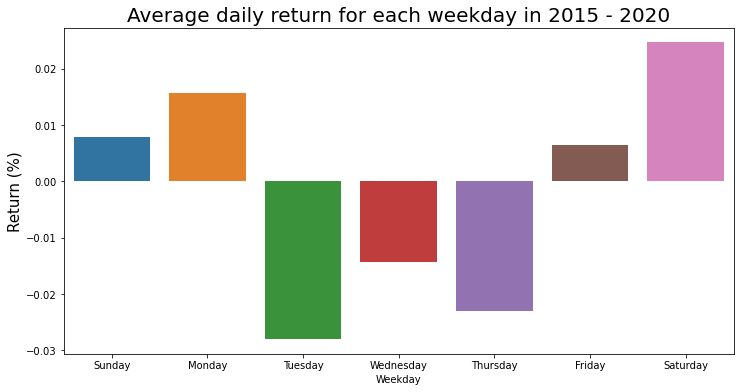

In [53]:
x = df["Weekday"]  # เสนอกราฟแกน x ตามจำนวนวัน  
y = df_weekday_mean["log"]  # เสนอกราฟแกน y ตาม %ผลตอบแทน

df_weekday_mean = df_weekday_mean.reindex(['Sunday',"Monday", "Tuesday", "Wednesday", "Thursday", "Friday","Saturday"])
df_weekday_mean

# แสดงผลตอบแทนตามวัน

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.barplot(x=df_weekday_mean.index, y=y, data=df_weekday_mean)
ax = plt.ylabel("Return (%)", size=15)
ax = plt.title("Average daily return for each weekday in 2015 - 2020", size=20)
# plt.savefig('osbx1.png')
plt.show()

In [45]:
# help(ta.ma)
# help(df.ta)
#df.ta.indicators()


# Plot ranges data

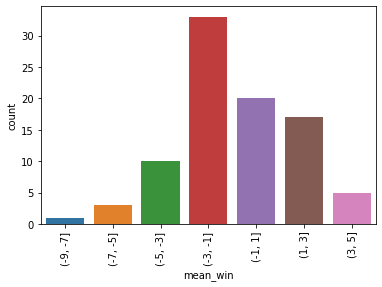

In [29]:
# Anlysis Data 
ranges = np.arange(int(df['consecutive_WL'].min()-2), int(df['consecutive_WL'].max()+2), 2)
df['mean_win'] = pd.cut(df['consecutive_WL'], ranges)

df['mean_count'] = df.groupby('mean_win')['mean_win'].transform('count')
ax = sns.countplot(x="mean_win", data=df)
xx = plt.setp(ax.get_xticklabels(), rotation=90)

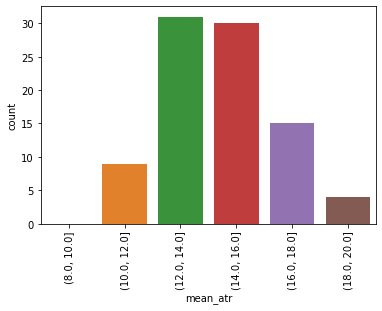

In [32]:
# Anlysis Data ranges 
ranges = np.arange(int(df['P_ATR'].min()-2.0), int(df['P_ATR'].max()+2.0), 2.0)
df['mean_atr'] = pd.cut(df['P_ATR'], ranges)

df['mean_count_atr'] = df.groupby('mean_atr')['mean_atr'].transform('count')
ax = sns.countplot(x="mean_atr", data=df)
xx = plt.setp(ax.get_xticklabels(), rotation=90)

In [45]:
float(df['hurst'].max()+0.1)

0.9088666635788134

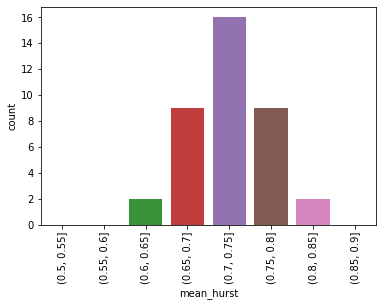

In [50]:
# Anlysis Data ranges 
ranges = np.arange(start=0.5, stop = float(df['hurst'].max()+0.1),step= 0.05)
df['mean_hurst'] = pd.cut(df['hurst'], ranges)

df['mean_count_hurst'] = df.groupby('mean_hurst')['mean_hurst'].transform('count')
ax = sns.countplot(x="mean_hurst", data=df)
xx = plt.setp(ax.get_xticklabels(), rotation=90)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Daily Return  SOL/USD')

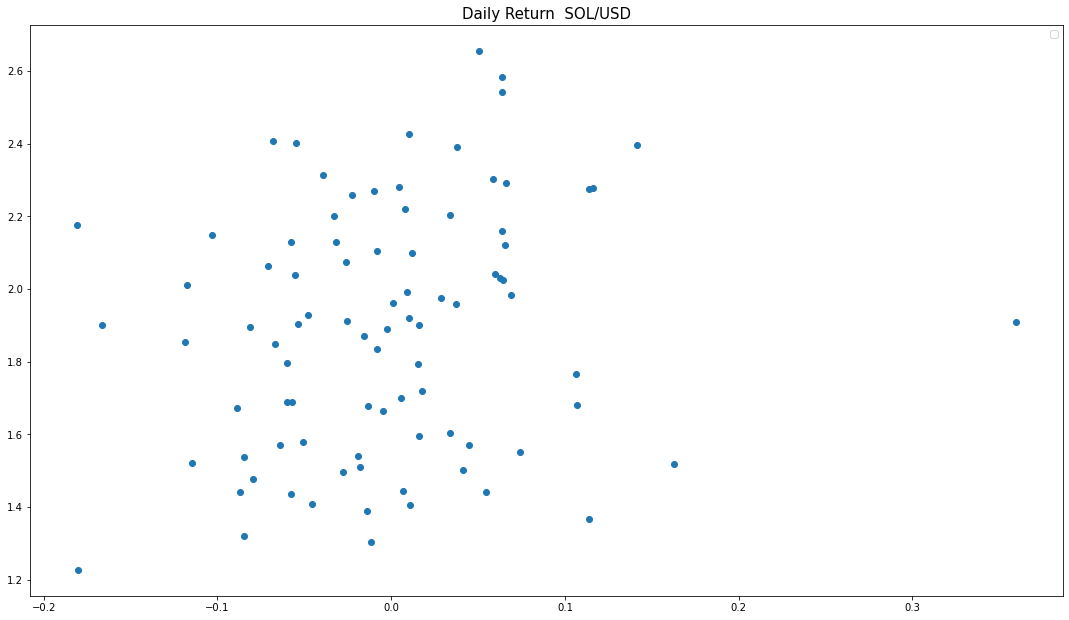

In [51]:
title =f'Daily Return  SOL/USD'
plt.scatter(x=df.close.pct_change(),y=df.close)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title(title,fontsize=15)

# vectorbt

In [56]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
# vbt.settings.portfolio["init_cash"] = 100
vbt.settings.portfolio["fees"] = 0.0025 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0025 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,100.0
size,inf
size_type,amount
fees,0.0025
fixed_fees,0.0
slippage,0.0025
reject_prob,0.0
min_size,0.0


In [57]:
start_date = dt(2020, 1, 1) # Adjust as needed
end_date = dt(2021, 12, 1)   # Adjust as needed

In [58]:

symbols= 'BTC/USD'

def dowload_ticker(tickers: list,start:dt, same_start: bool = False,**kwarg):
    if isinstance(tickers, str):
        # convert str to list
        tickers = [tickers]

    if not isinstance(tickers, list) or len(tickers) == 0:
        print("Must be a non-empty list of tickers or symbols")
        return

    all_data = dict()
    
    for symbols in tickers:
        res= ex.fetch_ohlcv(symbols,'1d',since=int(start.timestamp()*1000),**kwarg)
        df1 =pd.DataFrame(res,columns=['date','open','high','low','close','volume'])
        df1['date']=df1['date'].apply(ex.iso8601)
        df1['date']=pd.to_datetime(df1['date'])
        df1= df1.set_index('date')
        all_data[symbols] =  df1

    if same_start and len(tickers) > 1:
        min_date = get_min_date(all_data)
        print(f"[i] Earliest Common Date: {min_date}")
    #     for symbols,df in all_data.items():
    #         result = {symbols:df[df.index > min_date ].copy()}
        result = {symbols:df[df.index > min_date].copy() for symbols,df in all_data.items()}
    else:
        result = all_data
        
    print(f"[*] Download Complete\n")        
        
    return result 

def get_min_date(data:dict):
    """Returns index of the earliest common index of all DataFrames in the dict"""
    min_date =  None
    for df in data.values():
        if min_date is None:
            min_date = df.index[0]
        elif min_date < df.index[0]:
            min_date = df.index[0]
    return min_date         


def show_data(d: dict):
    [print(f"{t} [{df.index[0]} - {df.index[-1]}]: {df.shape} {df.ta.time_range:.2f} years") for t,df in d.items()]
    
    
def dtmask(df: pd.DataFrame, start: dt, end: dt):
    return df.loc[(df.index >= start.strftime("%Y-%m-%d %H:%M:%S")) & (df.index <= end.strftime("%Y-%m-%d %H:%M:%S")), :].copy()

In [59]:
benchmark_tickers = ["ETH", "BTC"]
asset_tickers = ["SOL", "BNB", "FTT"]
all_tickers = benchmark_tickers + asset_tickers
benchmark_tickers = [i +'/USD' for i in benchmark_tickers]
all_tickers = [i +'/USD' for i in all_tickers]
asset_tickers = [i +'/USD' for i in asset_tickers]

print("Tickers by index #")
print("="*100)
print(f"Benchmarks: {', '.join([f'{k}: {v}' for k,v in enumerate(benchmark_tickers)])}")
print(f"    Assets: {', '.join([f'{k}: {v}' for k,v in enumerate(asset_tickers)])}")
print(f"       All: {', '.join([f'{k}: {v}' for k,v in enumerate(all_tickers)])}")

Tickers by index #
Benchmarks: 0: ETH/USD, 1: BTC/USD
    Assets: 0: SOL/USD, 1: BNB/USD, 2: FTT/USD
       All: 0: ETH/USD, 1: BTC/USD, 2: SOL/USD, 3: BNB/USD, 4: FTT/USD


In [60]:
all_data = dowload_ticker(all_tickers,start= start_date,same_start=True)


assets = dowload_ticker(asset_tickers,start= start_date, same_start=False)
benchmarks = dowload_ticker(benchmark_tickers,start= start_date, same_start=False)

show_data(all_data)
print("Available Data:")
print("="*100)
print(f"Benchmarks: {', '.join(benchmarks.keys())}")
print(f"Assets: {', '.join(assets.keys())}")

[i] Earliest Common Date: 2020-07-27 00:00:00+00:00
[*] Download Complete

[*] Download Complete

[*] Download Complete

ETH/USD [2020-07-28 00:00:00+00:00 - 2022-01-02 00:00:00+00:00]: (524, 5) 2.08 years
BTC/USD [2020-07-28 00:00:00+00:00 - 2022-01-02 00:00:00+00:00]: (524, 5) 2.08 years
SOL/USD [2020-07-28 00:00:00+00:00 - 2022-01-02 00:00:00+00:00]: (524, 5) 2.08 years
BNB/USD [2020-07-28 00:00:00+00:00 - 2022-01-02 00:00:00+00:00]: (524, 5) 2.08 years
FTT/USD [2020-07-28 00:00:00+00:00 - 2022-01-02 00:00:00+00:00]: (524, 5) 2.08 years
Available Data:
Benchmarks: ETH/USD, BTC/USD, SOL/USD, BNB/USD, FTT/USD
Assets: ETH/USD, BTC/USD, SOL/USD, BNB/USD, FTT/USD


In [61]:
# call by symbols on dict {'symbols':pd.DataFrame}
assets['ETH/USD']

,open,high,low,close,volume
date,,,,,
2020-01-01 00:00:00+00:00,128.59,132.50,128.16,130.10,3.973496e+04
2020-01-02 00:00:00+00:00,130.10,130.13,126.02,126.73,7.830341e+04
2020-01-03 00:00:00+00:00,126.73,134.80,125.53,134.26,4.005650e+05
2020-01-04 00:00:00+00:00,134.19,135.57,132.32,134.08,6.168000e+04
2020-01-05 00:00:00+00:00,134.08,138.05,134.08,135.18,1.216596e+05
...,...,...,...,...,...
2021-12-29 00:00:00+00:00,3793.60,3828.00,3603.90,3628.70,4.482073e+08
2021-12-30 00:00:00+00:00,3628.70,3769.20,3582.60,3709.50,2.826543e+08
2021-12-31 00:00:00+00:00,3709.50,3815.90,3621.80,3676.50,4.168901e+08


In [79]:
benchmark_name = "ETH/USD" # Select a Benchmark
asset_name = "FTT/USD" # Select an Asset

benchmarkdf = benchmarks[benchmark_name]
assetdf     = assets[asset_name]

# Set True if you want to constrain Data between start_date & end_date
common_range = True
if common_range:
    crs = f" from {start_date} to {end_date}"
    benchmarkdf = dtmask(benchmarkdf, start_date, end_date)
    assetdf = dtmask(assetdf, start_date, end_date)
    


# Update DataFrame names
benchmarkdf.name = benchmark_name
assetdf.name = asset_name
print(f"Analysis of: {benchmarkdf.name} and {assetdf.name}{crs if common_range else ''}")

Analysis of: ETH/USD and FTT/USD from 2020-01-01 00:00:00 to 2021-12-01 00:00:00


# Signal from vectorbt

In [63]:
trend_kwargs = {"mamode": "ema", "fast": 20, "slow": 100}


# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame, mamode: str = "sma", fast: int = 50, slow: int = 200):
    return ta.ma(mamode, df.close, length=fast) > ta.ma(mamode, df.close, length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

In [64]:
def _signal(df:pd.DataFrame , mamode:'str' = 'ema' ,fast:int= 50 , slow:int=200):
    return ta.ma(mamode,df['close'],length=fast) >ta.ma(mamode,df['close'],length=slow)
    

<AxesSubplot:title={'center':'ETH/USD'}, xlabel='date'>

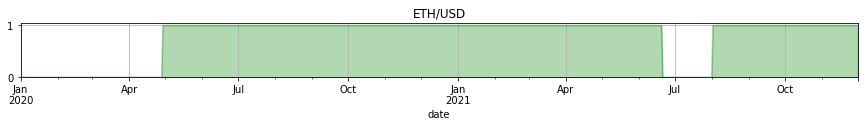

In [95]:
trend_kwargs = {"mamode": "ema", "fast": 20, "slow": 100}

benchmark_trends = _signal(benchmarkdf, **trend_kwargs)
benchmark_trends.copy().astype(int).plot(figsize=(15,1),kind='area',color=['green'],grid=True,alpha=0.3, title=f'{benchmarkdf.name}')

<AxesSubplot:title={'center':'FTT/USD'}, xlabel='date'>

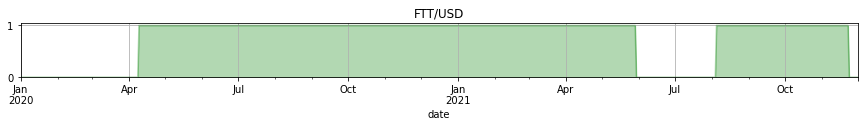

In [69]:
asset_trends = _signal(assetdf, **trend_kwargs)

asset_trends.copy().astype(int).plot(figsize=(15,1),kind='area',color=['green'],grid=True,alpha=0.3, title=f'{assetdf.name}')

In [96]:
benchmark_trends 


date
2020-01-01 00:00:00+00:00    False
2020-01-02 00:00:00+00:00    False
2020-01-03 00:00:00+00:00    False
2020-01-04 00:00:00+00:00    False
2020-01-05 00:00:00+00:00    False
                             ...  
2021-11-27 00:00:00+00:00     True
2021-11-28 00:00:00+00:00     True
2021-11-29 00:00:00+00:00     True
2021-11-30 00:00:00+00:00     True
2021-12-01 00:00:00+00:00     True
Length: 701, dtype: bool

In [66]:
ta.tsignals

<function pandas_ta.trend.tsignals.tsignals(trend, asbool=None, trend_reset=0, trade_offset=None, drift=None, offset=None, **kwargs)>

In [71]:
# trade_offset = 0 for Live Signals (close is last price)
# trade_offset = 1 for Backtesting
# convert bool array to signal dataframe

benchmark_signals = assetdf.ta.tsignals(benchmark_trends, asbool=True, trade_offset=LIVE, append=False)
benchmark_signals.tail()

NameError: name 'benchmark_trends' is not defined

In [614]:
asset_signals = assetdf.ta.tsignals(asset_trends, asbool=True, trade_offset=LIVE, append=False)
asset_signals.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
date,,,,
2021-11-27 00:00:00+00:00,False,0,False,False
2021-11-28 00:00:00+00:00,False,0,False,False
2021-11-29 00:00:00+00:00,False,0,False,False
2021-11-30 00:00:00+00:00,False,0,False,False
2021-12-01 00:00:00+00:00,False,0,False,False


# Backtest Reports

In [68]:
def combine_stats(pf: vbt.portfolio.base.Portfolio, ticker: str, strategy: str, mode: int = 0):
    header = pd.Series({
        "Run Time": ta.get_time(full=False, to_string=True),
        "Mode": "LIVE" if mode else "TEST",
        "Strategy": strategy,
        "Direction": vbt.settings.portfolio["signal_direction"],
        "Symbol": ticker.upper(),
        "Fees [%]": 100 * vbt.settings.portfolio["fees"],
        "Slippage [%]": 100 * vbt.settings.portfolio["slippage"],
        "Accumulate": vbt.settings.portfolio["accumulate"],
    })
    rstats = pf.returns_stats().dropna(axis=0).T
    stats = pf.stats().dropna(axis=0).T
    joint = pd.concat([header, stats, rstats])
    return joint[~joint.index.duplicated(keep="first")]






def trade_table(pf: vbt.portfolio.base.Portfolio, k: int = 1, total_fees: bool = False):
    if not isinstance(pf, vbt.portfolio.base.Portfolio): return
    k = int(k) if isinstance(k, int) and k > 0 else 1

    df = pf.trades.records[["status", "direction", "size", "entry_price", "exit_price", "return", "pnl", "entry_fees", "exit_fees"]]
    if total_fees:
        df["total_fees"] = df["entry_fees"] + df["exit_fees"]

    print(f"\nLast {k} of {df.shape[0]} Trades\n{df.tail(k)}\n")

In [85]:
benchmarkpf_bnh

In [84]:
# Benchmark Buy and Hold (BnH) Strategy
LIVE = 0

benchmarkpf_bnh = vbt.Portfolio.from_holding(benchmarkdf.close)
print(trade_table(benchmarkpf_bnh))
# print(benchmarkpf_bnh.trades.records[["status", "direction", "size", "entry_price", "exit_price", "return", "pnl", "entry_fees", "exit_fees"]])
combine_stats(benchmarkpf_bnh, benchmarkdf.name, "MA CROSS OVER", LIVE)


Last 1 of 1 Trades
   status  direction      size  entry_price  exit_price     return  \
0       0          0  0.764811    130.42525      4586.5  34.163237   

           pnl  entry_fees  exit_fees  
0  3407.804159    0.249377        0.0  

None


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\vectorbt\portfolio\trades.py:407: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\vectorbt\portfolio\trades.py:446: RuntimeWarning: invalid value encountered in true_divide
  profit_factor = total_win / np.abs(total_loss)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\vectorbt\portfolio\trades.py:407: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)


Run Time                     Sunday January 2, 2022, NYSE: 12:43:57
Mode                                                           TEST
Strategy                                              MA CROSS OVER
Direction                                                  longonly
Symbol                                                      ETH/USD
Fees [%]                                                       0.25
Slippage [%]                                                   0.25
Accumulate                                                    False
Start                                     2020-01-01 00:00:00+00:00
End                                       2021-12-01 00:00:00+00:00
Period                                            701 days 00:00:00
Start Value                                                   100.0
End Value                                               3507.804159
Total Return [%]                                        3407.804159
Benchmark Return [%]                            

In [74]:
# Asset Buy and Hold (BnH) Strategy
assetpf_bnh = vbt.Portfolio.from_holding(assetdf.close)
# print(trade_table(assetpf_bnh))
combine_stats(assetpf_bnh, assetdf.name, "Buy and Hold", LIVE)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\vectorbt\portfolio\trades.py:407: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\vectorbt\portfolio\trades.py:446: RuntimeWarning: invalid value encountered in true_divide
  profit_factor = total_win / np.abs(total_loss)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\vectorbt\portfolio\trades.py:407: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)


Run Time                     Sunday January 2, 2022, NYSE: 10:41:31
Mode                                                           TEST
Strategy                                               Buy and Hold
Direction                                                  longonly
Symbol                                                      FTT/USD
Fees [%]                                                       0.25
Slippage [%]                                                   0.25
Accumulate                                                    False
Start                                     2020-01-01 00:00:00+00:00
End                                       2021-12-01 00:00:00+00:00
Period                                            701 days 00:00:00
Start Value                                                   100.0
End Value                                               2360.266084
Total Return [%]                                        2260.266084
Benchmark Return [%]                            

In [83]:
# Benchmark Portfolio from Trade Signals
benchmarkpf_signals = vbt.Portfolio.from_signals(
    benchmarkdf.close,
    entries=benchmark_signals.TS_Entries,
    exits=benchmark_signals.TS_Exits,
)
trade_table(benchmarkpf_signals, k=5)
combine_stats(benchmarkpf_signals, benchmarkdf.name, "Long Strategy", LIVE)

NameError: name 'benchmark_signals' is not defined

In [82]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    assetdf.close,
    entries=asset_signals.TS_Entries,
    exits=asset_signals.TS_Exits,
)
trade_table(assetpf_signals, k=5)
combine_stats(assetpf_signals, assetdf.name, "Long Strategy", LIVE)

NameError: name 'asset_signals' is not defined

In [ ]:
# strategy = 'Buy and Hold'
# ticker = benchmarkdf.name
# pf = vbt.Portfolio.from_holding(benchmarkdf.close)
# header = pd.Series({
#     "Run Time": ta.get_time(full=False, to_string=True),
#     "Mode": "TEST",
#     "Strategy": strategy,
#     "Direction": vbt.settings.portfolio["signal_direction"],
#     "Symbol": ticker.upper(),
#     "Fees [%]": 100 * vbt.settings.portfolio["fees"],
#     "Slippage [%]": 100 * vbt.settings.portfolio["slippage"],
#     "Accumulate": vbt.settings.portfolio["accumulate"],
# })
# rstats = pf.returns_stats().dropna(axis=0).T
# stats = pf.stats().dropna(axis=0).T
# joint = pd.concat([header, stats, rstats])
# joint =joint[~joint.index.duplicated(keep="first")]
# joint

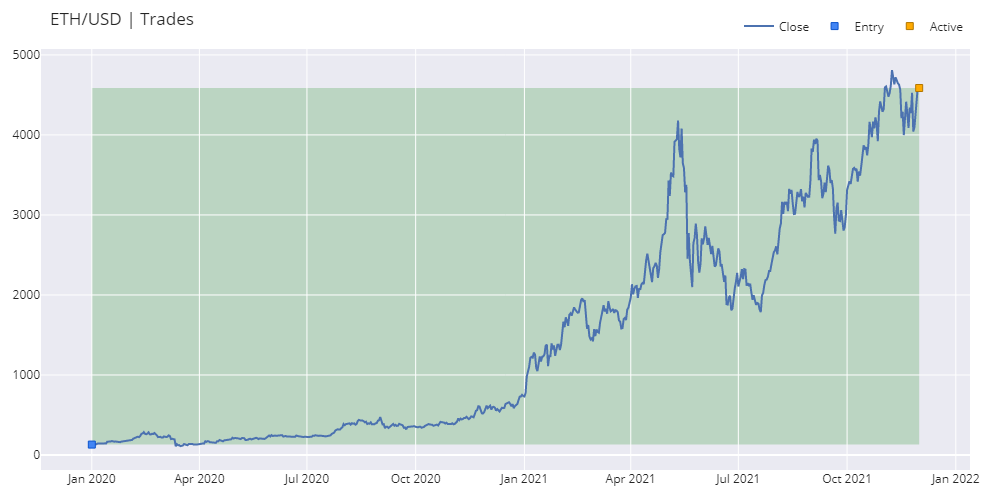

In [102]:
vbt.settings.set_theme("seaborn")
benchmarkpf_bnh.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()


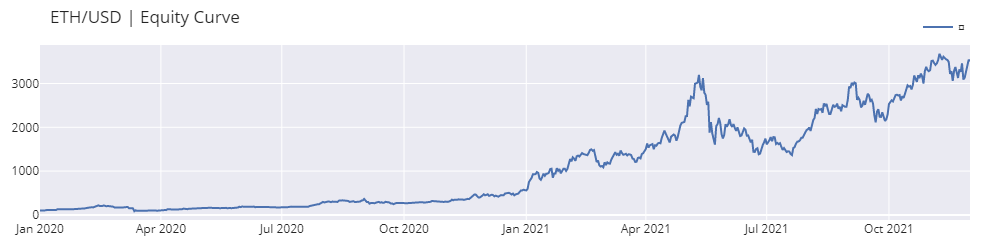

In [103]:
benchmarkpf_bnh.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()


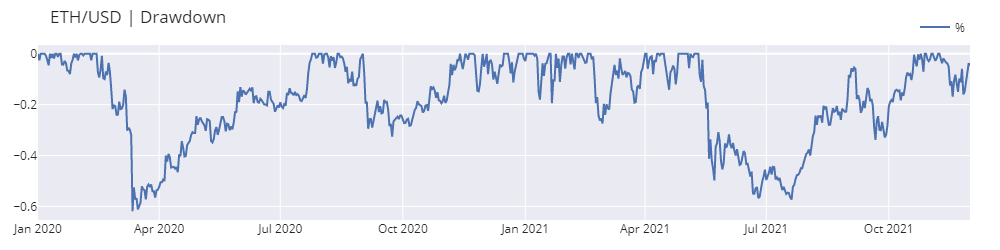

In [104]:
benchmarkpf_bnh.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()


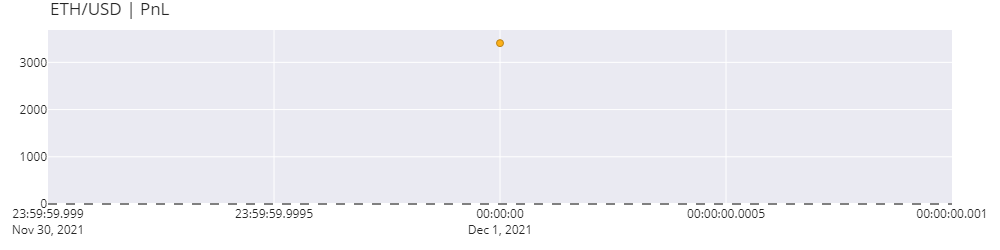

In [105]:
benchmarkpf_bnh.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()


In [683]:
benchmarkpf_bnh.active_returns().vbt.plot(title=f"{benchmarkdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()


AttributeError: 'Portfolio' object has no attribute 'active_returns'

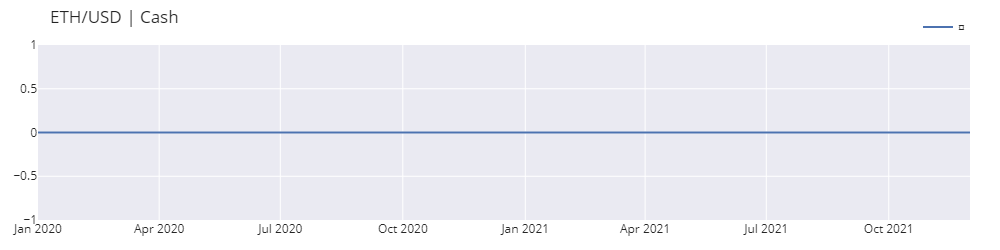

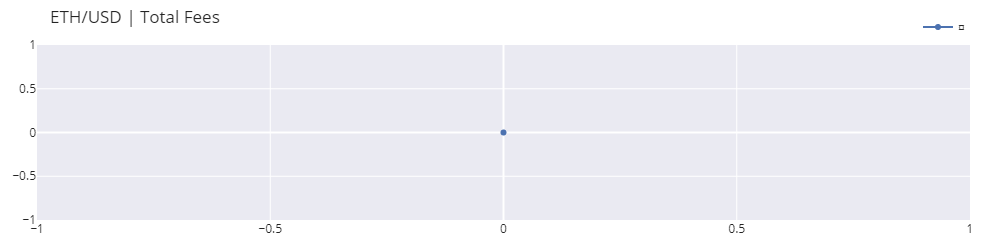

In [685]:
benchmarkpf_bnh.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()


total_assetfees = benchmarkpf_bnh.trades.records_readable["Entry Fees"] + benchmarkpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

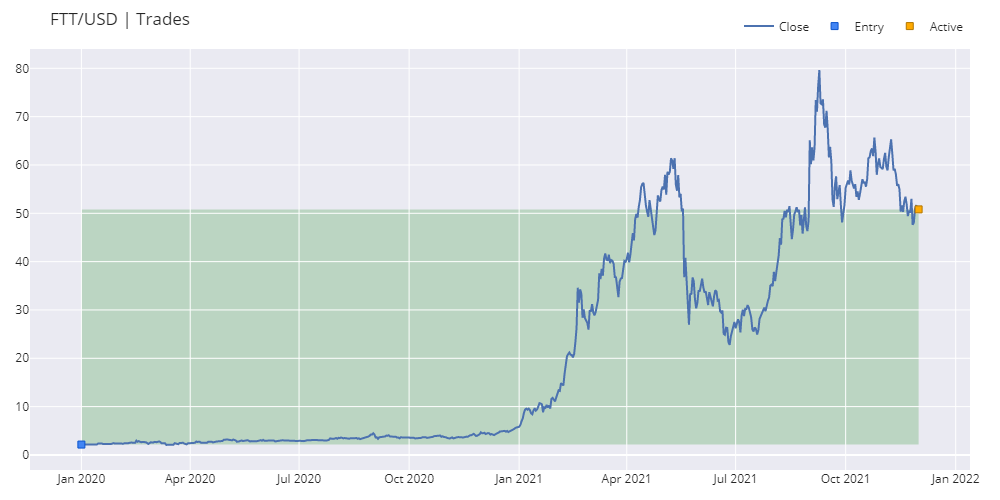

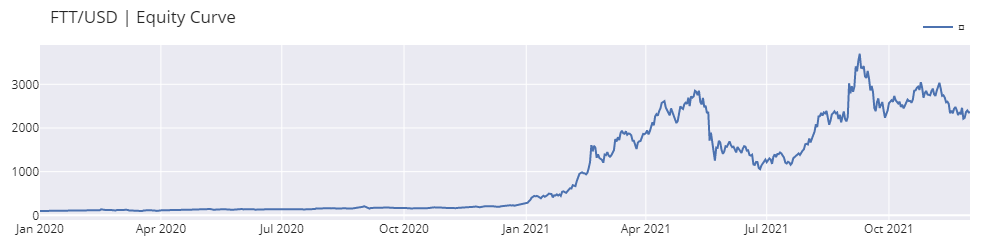

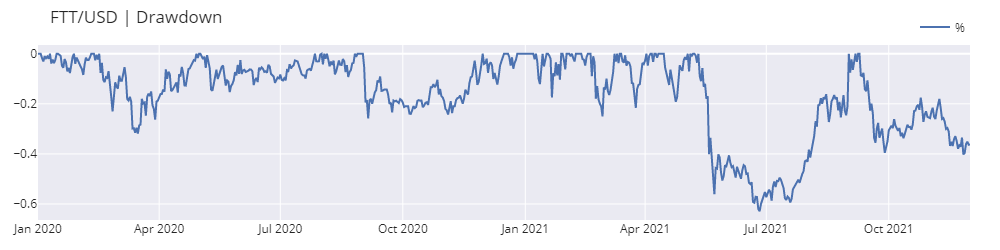

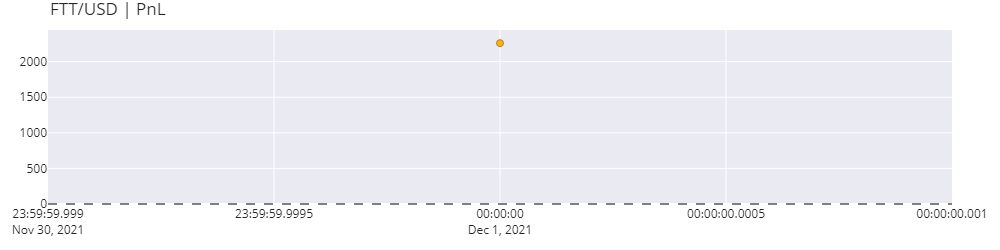

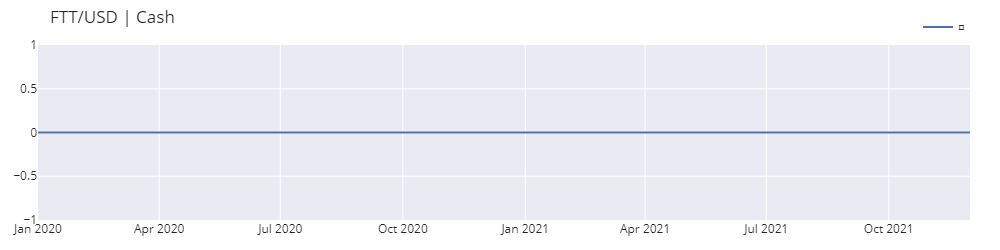

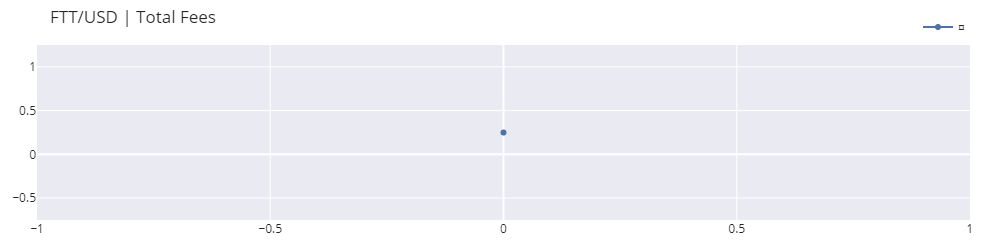

In [106]:
assetpf_bnh.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()
assetpf_bnh.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()
assetpf_bnh.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()
assetpf_bnh.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()
# assetpf_bnh.active_returns().vbt.plot(title=f"{assetdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()
assetpf_bnh.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

total_assetfees = assetpf_bnh.trades.records_readable["Entry Fees"] + assetpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

In [692]:
vbt.settings.set_theme("dark")


# signal strategy

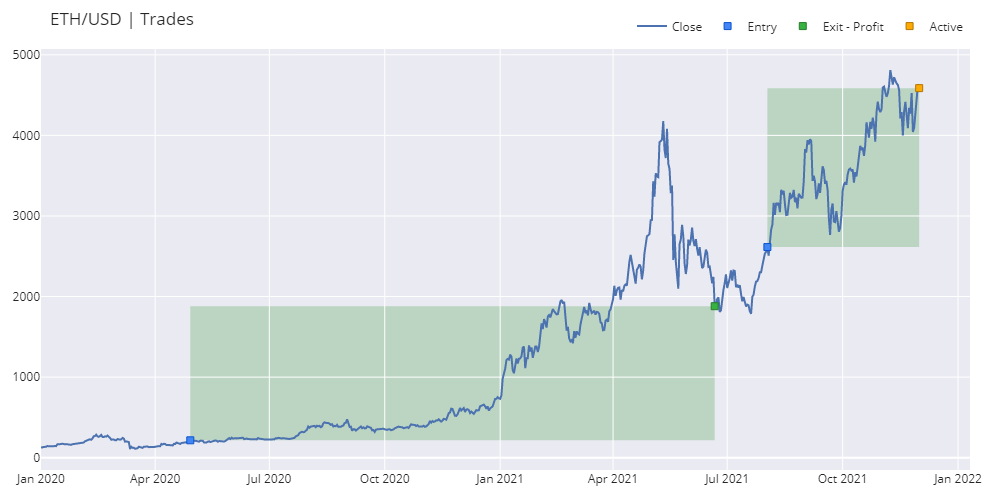

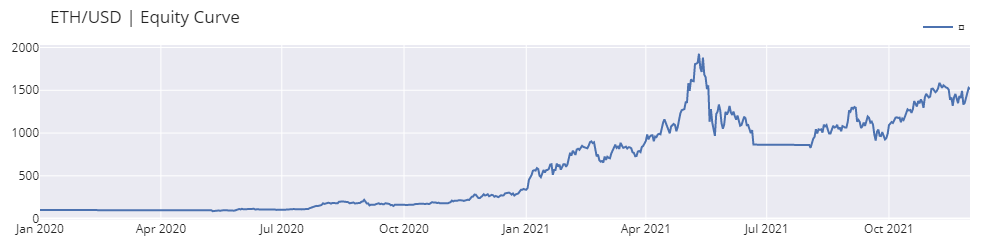

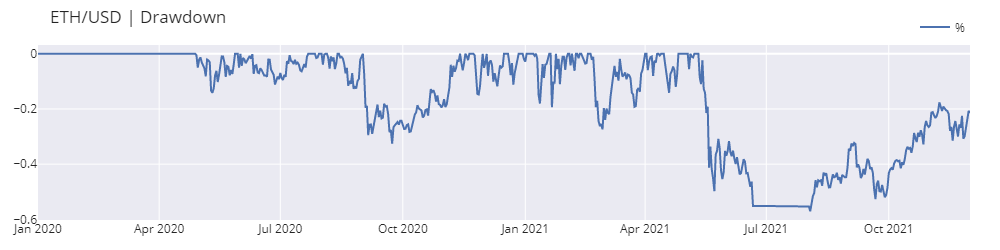

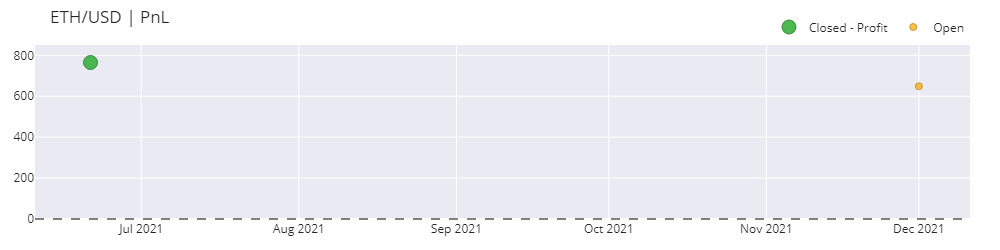

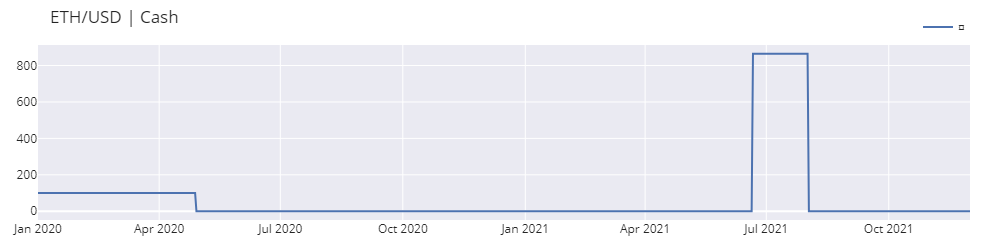

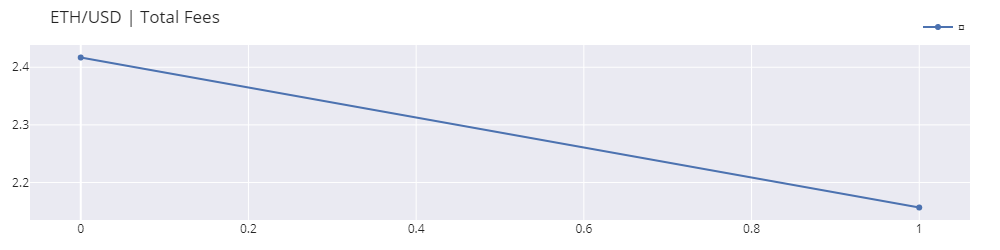

In [109]:
# plot  signal 
# plot equity
# plot Drawdowns
# plot pnl per trades

benchmarkpf_signals.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()
benchmarkpf_signals.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()
benchmarkpf_signals.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()
benchmarkpf_signals.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()
benchmarkpf_signals.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()
total_assetfees = benchmarkpf_signals.trades.records_readable["Entry Fees"] + benchmarkpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

In [108]:
# plot  signal 
# plot equity
# plot Drawdowns
# plot pnl per trades

# https://github.com/twopirllc/pandas-ta/blob/main/examples/VectorBT_Backtest_with_Pandas_TA.ipynb
assetpf_signals.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()
assetpf_signals.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()
assetpf_signals.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()
assetpf_signals.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()
assetpf_signals.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()
total_assetfees = assetpf_signals.trades.records_readable["Entry Fees"] + assetpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

NameError: name 'assetpf_signals' is not defined

In [708]:
dir(assetpf_signals.trades)

['__annotations__',
 '__cached_closed',
 '__cached_count',
 '__cached_open',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_close',
 '_col_mapper',
 '_config',
 '_idx_field',
 '_iloc',
 '_indexing_kwargs',
 '_loc',
 '_metrics',
 '_records_arr',
 '_wrapper',
 'apply',
 'build_metrics_doc',
 'close',
 'closed',
 'closed_rate',
 'col',
 'col_mapper',
 'config',
 'copy',
 'count',
 'deep_getattr',
 'direction',
 'dumps',
 'duration',
 'entry_fees',
 'entry_idx',
 'entry_price',
 'exit_fees',
 'exit_idx',
 'exit_price',
 'expectancy',
 'filter_by_mask',
 'from_orders',
 'get_by_col_idxs',
 'id',
 'idx_field',
 'iloc',
 'indexing_func',
 'index

In [711]:
assetpf_signals.trades.records_readable

,Trade Id,Column,Size,Entry Date,Avg. Entry Price,Entry Fees,Exit Date,Avg. Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,36.737693,2020-04-09 00:00:00+00:00,2.722,0.0,2021-05-30 00:00:00+00:00,31.425,0.0,1054.481999,10.544820,Long,Closed,0
1,1,0,28.945993,2021-08-05 00:00:00+00:00,39.884,0.0,2021-11-24 00:00:00+00:00,50.120,0.0,296.291188,0.256644,Long,Closed,1


In [712]:
assetpf_signals.trades.records

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,position_id
0,0,0,36.737693,99,2.722,0.0,515,31.425,0.0,1054.481999,10.544820,0,1,0
1,1,0,28.945993,582,39.884,0.0,693,50.120,0.0,296.291188,0.256644,0,1,1


In [ ]:
# adjust mae mfe to signal reports, holding period